## Pretrained CNN Weights (`model1.pth`)

### Evaluating Hyperparameters

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score
import os
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from skimage import io


Training with LR=0.0001, Batch Size=16
Dataset loaded: 12 valid samples found.
Dataset loaded: 1 valid samples found.
Epoch 1/10, Train Loss: 1.1050, Val Loss: 1.1378, Val Accuracy: 0.0000
Epoch 2/10, Train Loss: 1.0707, Val Loss: 1.1338, Val Accuracy: 0.0000
Epoch 3/10, Train Loss: 1.0330, Val Loss: 1.1284, Val Accuracy: 0.0000
Epoch 4/10, Train Loss: 1.0255, Val Loss: 1.1210, Val Accuracy: 0.0000
Epoch 5/10, Train Loss: 0.9768, Val Loss: 1.1118, Val Accuracy: 0.0000
Epoch 6/10, Train Loss: 0.9709, Val Loss: 1.1002, Val Accuracy: 0.0000
Epoch 7/10, Train Loss: 0.9330, Val Loss: 1.0878, Val Accuracy: 0.0000
Epoch 8/10, Train Loss: 0.8892, Val Loss: 1.0706, Val Accuracy: 1.0000
Epoch 9/10, Train Loss: 0.8766, Val Loss: 1.0539, Val Accuracy: 1.0000
Epoch 10/10, Train Loss: 0.8851, Val Loss: 1.0312, Val Accuracy: 1.0000

Training with LR=0.0001, Batch Size=32
Dataset loaded: 12 valid samples found.
Dataset loaded: 1 valid samples found.
Epoch 1/10, Train Loss: 1.1378, Val Loss: 1.1265, V

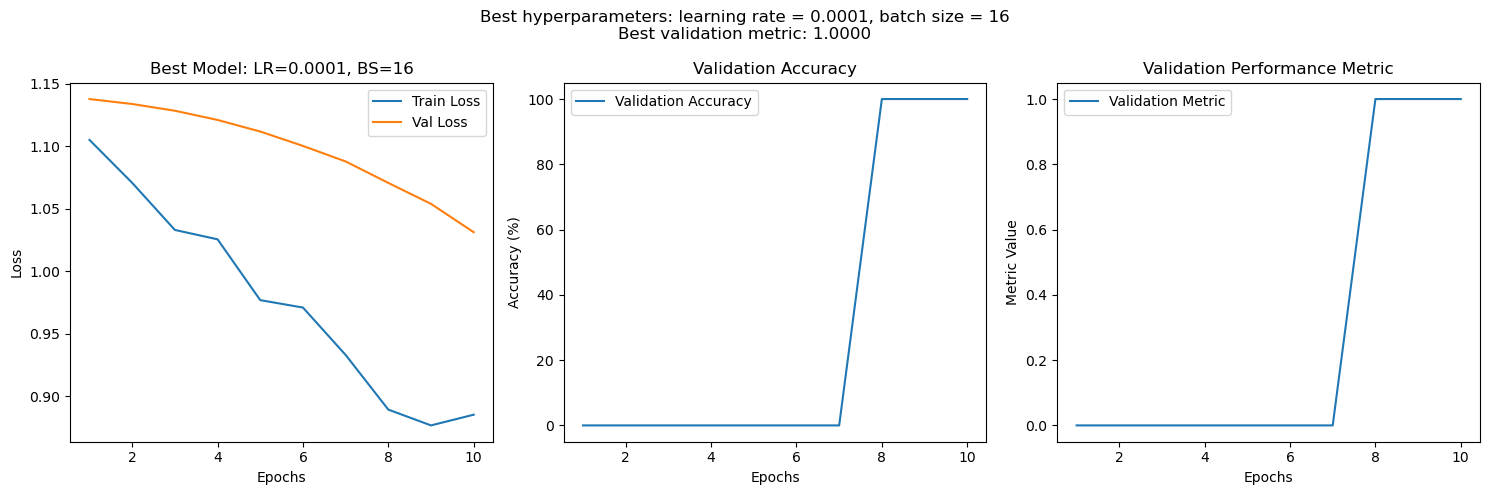


Summary of all hyperparameter combinations:
LR	BS	Final Val Loss	Final Val Acc	Final Metric
------------------------------------------------------------
0.0001	16	1.0312	100.00%	1.0000
0.0001	32	1.0595	100.00%	1.0000
0.0001	64	1.0192	100.00%	1.0000
0.001	16	0.0000	100.00%	1.0000
0.001	32	0.0283	100.00%	1.0000
0.001	64	0.0001	100.00%	1.0000
0.01	16	0.0035	100.00%	1.0000
0.01	32	1.2755	0.00%	0.0000
0.01	64	0.0035	100.00%	1.0000
0.05	16	0.0000	100.00%	1.0000
0.05	32	0.0000	100.00%	1.0000
0.05	64	13.6197	0.00%	0.0000
0.1	16	0.0000	100.00%	1.0000
0.1	32	0.0000	100.00%	1.0000
0.1	64	0.0000	100.00%	1.0000

Best hyperparameters: Learning Rate = 0.0001, Batch Size = 16
Best Validation Metric: 1.0000


In [ ]:
results = {}

learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1]
batch_sizes = [16, 32, 64]
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_metric = 0
best_params = None

for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"\nTraining with LR={lr}, Batch Size={batch_size}")

        #Create Data Loaders
        train_loader = DataLoader(ChestXrayDataset(train_csv, image_dir, transform), batch_size=batch_size, shuffle=True, num_workers=1)
        val_loader = DataLoader(ChestXrayDataset(val_csv, image_dir, transform), batch_size=batch_size, shuffle=False, num_workers=1)

        #Initialize Model
        model = DiseaseCNN(num_classes=3).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        #Track metrics
        train_losses, val_losses, val_accs, val_metrics = [], [], [], []

        #Training Loop
        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0

            for batch in train_loader:
                images, labels = batch["x"].to(device), batch["y"].to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * images.size(0)

            epoch_train_loss = running_loss / len(train_loader.dataset)
            train_losses.append(epoch_train_loss)

            #Validation phase
            model.eval()
            running_loss = 0.0
            all_labels, all_preds, all_probs = [], [], []

            with torch.no_grad():
                for batch in val_loader:
                    images, labels = batch["x"].to(device), batch["y"].to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    running_loss += loss.item() * images.size(0)

                    _, preds = torch.max(outputs, 1)
                    probs = torch.softmax(outputs, dim=1)

                    all_labels.extend(labels.cpu().numpy())
                    all_preds.extend(preds.cpu().numpy())
                    all_probs.extend(probs.cpu().numpy())

            epoch_val_loss = running_loss / len(val_loader.dataset)
            val_losses.append(epoch_val_loss)

            val_acc = accuracy_score(all_labels, all_preds) * 100
            val_accs.append(val_acc)

            try:
                all_labels_one_hot = np.eye(3)[all_labels]
                all_probs_array = np.array(all_probs)
                if len(np.unique(all_labels)) == 3:  #Ensure all classes exist
                    macro_auc = roc_auc_score(all_labels_one_hot, all_probs_array, multi_class="ovr")
                    metric_name = "AUC"
                else:
                    macro_auc = val_acc / 100  
                    metric_name = "Accuracy"
            except Exception as e:
                print(f"AUC error: {e}. Using accuracy instead.")
                macro_auc = val_acc / 100
                metric_name = "Accuracy"

            val_metrics.append(macro_auc)
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val {metric_name}: {macro_auc:.4f}")

        results[(lr, batch_size)] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_accs": val_accs,
            "val_metrics": val_metrics
        }

        #Track best hyperparameters
        if macro_auc > best_metric:
            best_metric = macro_auc
            best_params = (lr, batch_size)

#Best Model Results Plot
if best_params:
    best_lr, best_bs = best_params
    best_results = results[best_params]

    plt.figure(figsize=(15, 5))

    #Loss plot
    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs+1), best_results['train_losses'], label="Train Loss")
    plt.plot(range(1, num_epochs+1), best_results['val_losses'], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Best Model: LR={best_lr}, BS={best_bs}")
    plt.legend()

    #Accuracy plot
    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs+1), best_results['val_accs'], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy")
    plt.legend()

    #AUC/Metric plot
    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs+1), best_results['val_metrics'], label="Validation Metric")
    plt.xlabel("Epochs")
    plt.ylabel("Metric Value")
    plt.title("Validation Performance Metric")
    plt.legend()

    plt.suptitle(f"Best hyperparameters: learning rate = {best_lr}, batch size = {best_bs}\nBest validation metric: {best_metric:.4f}", fontsize=12)
    plt.tight_layout()
    plt.show()

#Summary of all results
print("\nSummary of all hyperparameter combinations:")
print("LR\tBS\tFinal Val Loss\tFinal Val Acc\tFinal Metric")
print("-" * 60)
for (lr, bs), result in sorted(results.items()):
    print(f"{lr}\t{bs}\t{result['val_losses'][-1]:.4f}\t{result['val_accs'][-1]:.2f}%\t{result['val_metrics'][-1]:.4f}")

print(f"\nBest hyperparameters: Learning Rate = {best_params[0]}, Batch Size = {best_params[1]}")
print(f"Best Validation Metric: {best_metric:.4f}")


# Train the Network on the Entire Dataset

In [ ]:
# **Use Best Hyperparameters**
best_lr = best_params[0]
best_bs = best_params[1]
num_epochs = 15 

train_csv = "trainSet.csv"
val_csv = "validationSet.csv"
image_dir = "images"

class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_mapping = {"Cardiomegaly": 0, "Pneumothorax": 1, "Infiltration": 2}

        valid_samples = []
        for idx in range(len(self.data_frame)):
            img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0])
            label_str = str(self.data_frame.iloc[idx, 1]).strip()
            label = self.class_mapping.get(label_str, -1)

            if os.path.exists(img_path) and label in [0, 1, 2]:
                valid_samples.append({"image": img_path, "label": label})

        self.data_frame = pd.DataFrame(valid_samples)

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        img_name = sample["image"]
        label = int(sample["label"])

        image = Image.open(img_name).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return {"x": image, "y": torch.tensor(label, dtype=torch.long)}

#Define Data Transforms
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

#Create Data Loaders
train_loader = DataLoader(ChestXrayDataset(train_csv, image_dir, transform), batch_size=best_bs, shuffle=True, num_workers=1)
val_loader = DataLoader(ChestXrayDataset(val_csv, image_dir, transform), batch_size=best_bs, shuffle=False, num_workers=1)

#Define CNN Model
class DiseaseCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool(torch.relu(self.bn5(self.conv5(x))))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

#Initialize Model, Loss & Optimizer**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiseaseCNN(num_classes=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

#Training & Evaluation
train_losses, train_accs, val_losses, val_accs, val_aucs = [], [], [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for batch in train_loader:
        images, labels = batch["x"].to(device), batch["y"].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        # Compute accuracy
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accs.append(correct / total * 100)  #Convert to percentage

    #Validation Phase
    model.eval()
    val_loss, all_labels, all_preds = 0, [], []

    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch["x"].to(device), batch["y"].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.softmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_acc = accuracy_score(all_labels, np.argmax(all_preds, axis=1)) * 100
    val_accs.append(val_acc)

    try:
        val_auc = roc_auc_score(np.eye(3)[all_labels], np.array(all_preds), multi_class="ovr")
    except:
        val_auc = val_acc / 100  

    val_aucs.append(val_auc)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.2f}%, Val AUC: {val_auc:.4f}")

torch.save(model.state_dict(), "model1.pth")
print("Model1 saved as model1.pth")

#Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker="o")
plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("full_training_metrics.png")
plt.show()

### Occlusion Sensitivity of Trained CNN
Reference: https://arxiv.org/pdf/1311.2901.pdf

Visualization CSV columns: ['Image Index', 'Finding Label', 'Bbox [x', 'y', 'w', 'h]', 'Unnamed: 6']
First few rows of visualization CSV:
        Image Index Finding Label     Bbox [x           y           w  \
0  00000661_000.png  Cardiomegaly  298.847458  437.459895  548.881356   
1  00002176_007.png  Pneumothorax  258.979894  188.546032  107.276190   
2  00002435_005.png  Cardiomegaly  362.847458  480.271186  401.355932   
3  00007471_003.png  Pneumothorax  540.715344  106.192593  333.748148   

           h] Unnamed: 6  
0  428.474576          *  
1  115.944974        NaN  
2  298.305085        NaN  
3  483.284656        NaN  
✅ Dataset Loaded: 4 valid samples found.
✅ DiseaseCNN model successfully loaded from /scratch/ml9675/deep_learning/HW2/model1.pth


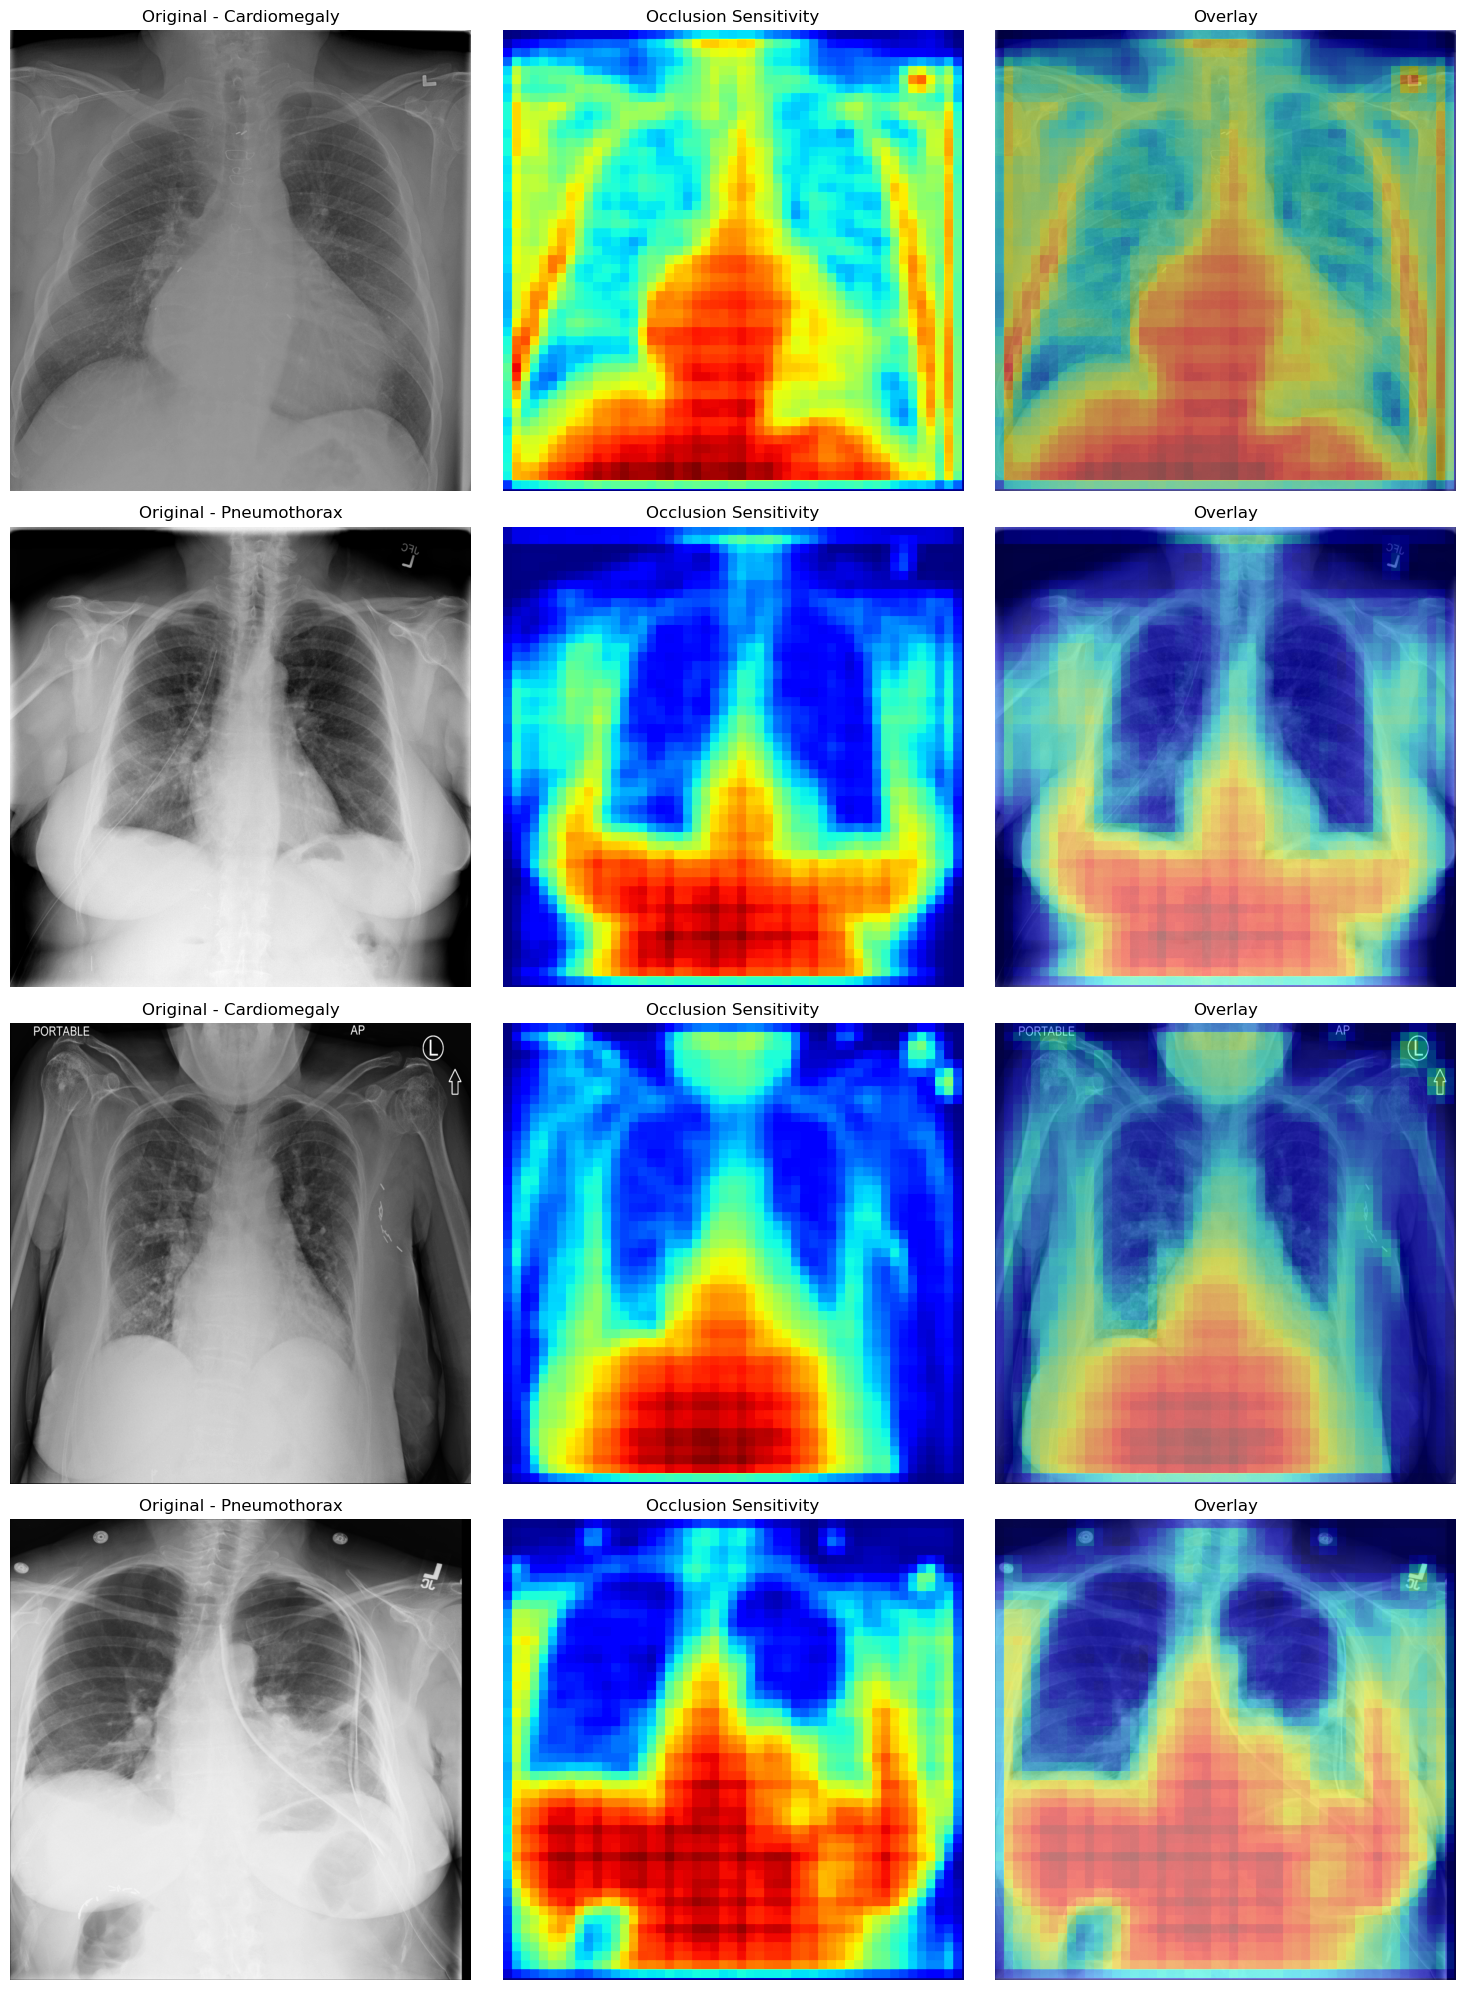

In [ ]:
#Load visualization CSV file and inspect
visualization_csv_path = "visualize.csv"
image_dir = "images"

try:
    visualization_df = pd.read_csv(visualization_csv_path)
    print("Visualization CSV columns:", visualization_df.columns.tolist())
    print("First few rows of visualization CSV:")
    print(visualization_df.head())
except Exception as e:
    print(f"Error loading visualization CSV: {e}")

#Define Dataset for Visualization
class VisualizationDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir):
        self.root_dir = root_dir
        self.label_map = {'Cardiomegaly': 0, 'Pneumothorax': 1, 'Infiltration': 2}

        df = pd.read_csv(csv_file)
        valid_samples = []
        missing_count = 0

        for idx in range(len(df)):
            img_path = os.path.join(root_dir, df.iloc[idx, 0])
            if os.path.exists(img_path):
                valid_samples.append({"image": img_path, "label": df.iloc[idx, 1]})
            else:
                missing_count += 1  

        self.data_frame = pd.DataFrame(valid_samples)
        print(f"Dataset Loaded: {len(self.data_frame)} valid samples found.")
        if missing_count > 0:
            print(f"Skipped {missing_count} missing images.")

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        sample = self.data_frame.iloc[idx]
        img_name = sample["image"]


        image = io.imread(img_name)


        if len(image.shape) == 2: 
            image = np.stack([image] * 3, axis=-1)  

        image = image / 255.0  #Normalize
        image = torch.FloatTensor(image).permute(2, 0, 1)
        label = self.label_map.get(sample["label"], -1)  

        return {"x": image, "y": label}


#Create Visualization Dataset
visualization_dataset = VisualizationDataset(
    csv_file=visualization_csv_path,
    root_dir=image_dir
)

valid_samples = len(visualization_dataset)
if valid_samples == 0:
    print("No valid images found. Exiting script.")
    exit()  #Stop execution if no valid images exist

class DiseaseCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(DiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 512)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool(torch.relu(self.bn5(self.conv5(x))))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

#Load DiseaseCNN with Weights from model1.pth
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiseaseCNN(num_classes=3).to(device)

model_path = "/scratch/ml9675/deep_learning/HW2/model1.pth"
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print(f"✅ DiseaseCNN model successfully loaded from {model_path}")
else:
    raise FileNotFoundError(f"Model file not found at {model_path}. Ensure training has been completed.")

#Occlusion Sensitivity Function
def occlusion_sensitivity(model, image, label, device, occlusion_size=40, stride=20):
    model.eval()
    width, height = image.shape[1], image.shape[2]

    image_tensor = torch.FloatTensor(image).unsqueeze(0).to(device)
    output = model(image_tensor)
    original_confidence = torch.softmax(output, dim=1)[0, label].item()

    heatmap = np.zeros((height, width))

    for h in range(0, height - occlusion_size + 1, stride):
        for w in range(0, width - occlusion_size + 1, stride):
            occluded_image = image.copy()
            occluded_image[0, h:h+occlusion_size, w:w+occlusion_size] = 0.0

            occluded_tensor = torch.FloatTensor(occluded_image).unsqueeze(0).to(device)
            occluded_output = model(occluded_tensor)
            occluded_confidence = torch.softmax(occluded_output, dim=1)[0, label].item()

            confidence_drop = original_confidence - occluded_confidence
            heatmap[h:h+occlusion_size, w:w+occlusion_size] += confidence_drop

    return heatmap

#Generate Occlusion Heatmaps
fig, axes = plt.subplots(valid_samples, 3, figsize=(15, 5 * valid_samples))

if valid_samples == 1:
    axes = [axes] 

valid_idx = 0  
for i in range(valid_samples):
    try:
        sample = visualization_dataset[i]
        image = sample["x"].numpy()
        label = sample["y"]

        class_names = ["Cardiomegaly", "Pneumothorax", "Infiltration"]
        class_name = class_names[label] if isinstance(label, int) and label < len(class_names) else f"Class {label}"

        axes[valid_idx][0].imshow(image[0], cmap="gray")
        axes[valid_idx][0].set_title(f"Original - {class_name}")
        axes[valid_idx][0].axis("off")

        heatmap = occlusion_sensitivity(model, image, label, device)

        axes[valid_idx][1].imshow(heatmap, cmap="jet")
        axes[valid_idx][1].set_title("Occlusion Sensitivity")
        axes[valid_idx][1].axis("off")

        axes[valid_idx][2].imshow(image[0], cmap="gray")
        axes[valid_idx][2].imshow(heatmap, cmap="jet", alpha=0.5)
        axes[valid_idx][2].set_title("Overlay")
        axes[valid_idx][2].axis("off")

        valid_idx += 1

    except Exception as e:
        print(f"Skipping sample {i} due to error: {e}")

plt.tight_layout()
plt.show()